In [58]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## 1. Data Import & Explore features

### 1.1 Data Import - Train Data 
- features : 10 
- rows : 891 but Age and Cabin features have missing values 

In [59]:
df_train = pd.read_csv("../input/titanic/train.csv")
df_train.set_index('PassengerId', inplace=True)
display(df_train.info())

#Cabin, Age has missing values 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


None

### 1.2 Missing Values
- Age, Cabin have missing values. 

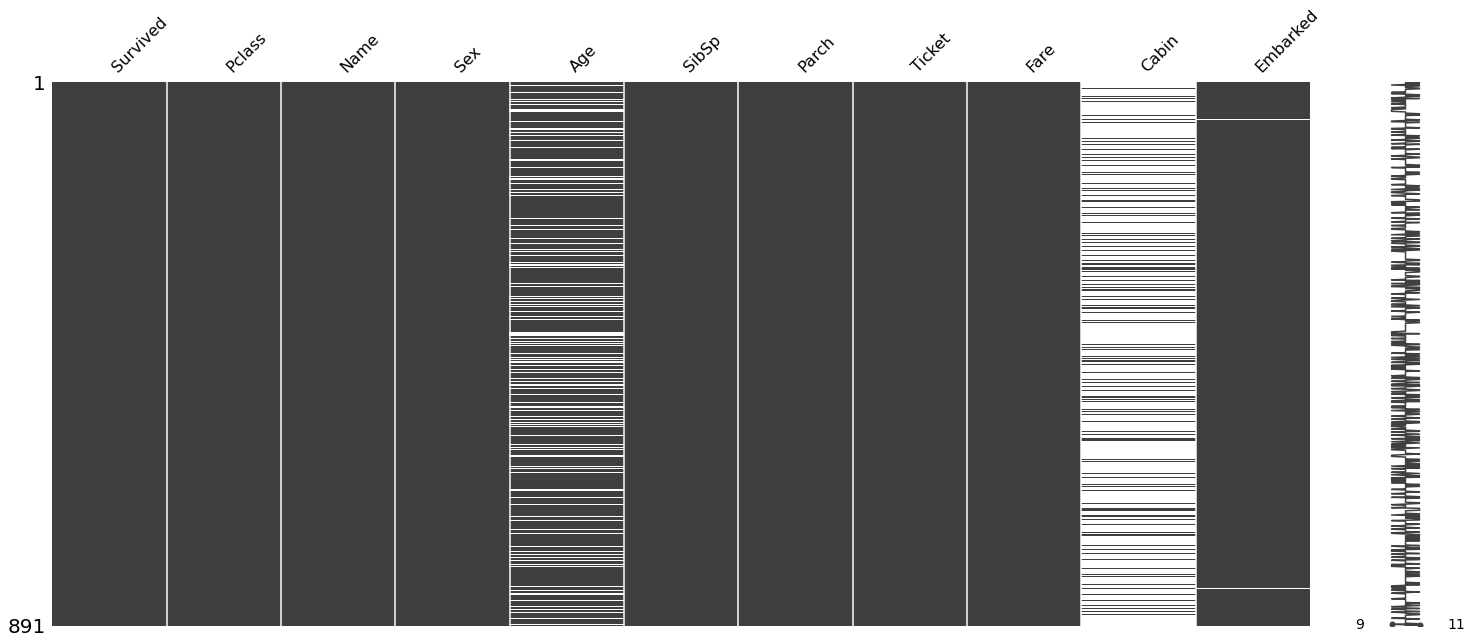

In [60]:
msno.matrix(df_train)

# missing values in 'Age', 'Cabin'

### 1.2.1 Dealing with missing values in 'Age' 
Most of those without Age records =3rd class, male, no SipSp, no Parch.
In particular, Pclass is the most outstanding feature among the rest,since Pclass shows a distinctive difference in all features.  
Therefore, it is reasonable to fill the missing values refering to the median age of each Pclass. 

In [61]:
df_train.Age.fillna(0, inplace=True)
df_train.Age.value_counts()

# how to deal with 177 missing values in Age 
# First, check other features of those without age records 

0.00     177
24.00     30
22.00     27
18.00     26
28.00     25
        ... 
36.50      1
55.50      1
66.00      1
23.50      1
0.42       1
Name: Age, Length: 89, dtype: int64

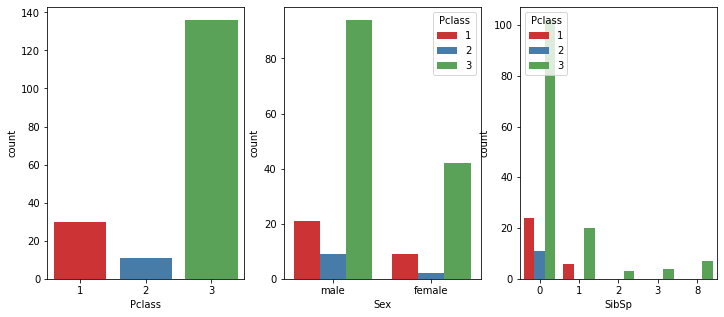

In [62]:
null_age=df_train['Age']==0 
temp=df_train[null_age]

fig=plt.figure(figsize=(12,5))
ax1=fig.add_subplot(1,3,1)
ax2=fig.add_subplot(1,3,2)
ax3=fig.add_subplot(1,3,3)
sns.countplot(x='Pclass', palette='Set1', data=temp, ax=ax1)
sns.countplot(x='Sex', palette='Set1', data=temp, ax=ax2, hue='Pclass')
sns.countplot(x='SibSp', palette='Set1', data=temp, ax=ax3, hue='Pclass')

plt.show()

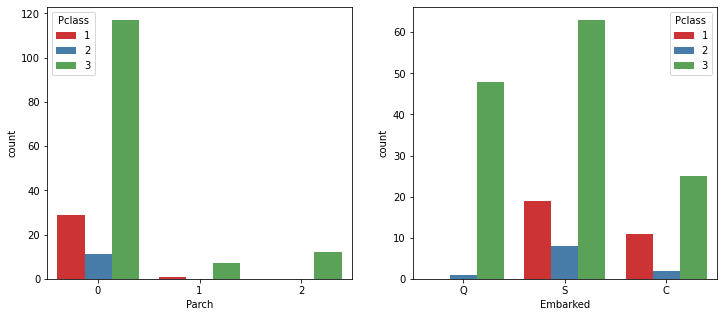

In [63]:
fig=plt.figure(figsize=(12,5))
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)

sns.countplot(x='Parch', palette='Set1', data=temp, ax=ax1, hue='Pclass')
sns.countplot(x='Embarked', palette='Set1', data=temp, ax=ax2, hue='Pclass')

plt.show()

### 1.2.2 Dealing with missing values in 'Cabin' 
In case of Pclass=2 or 3, the num of missing values is much more than that of existing values. So maybe, 'Cabin' is not so important to decide the survival of those with Pclass=2 or 3. 

Meanwhile, most of those with Pclass=1 had designated Cabin number, so Cabin data is an important predictor to the survival of those with Pclass=1 

So it is fine to to categorize Cabin  like .. 
for Pclass=2,3  .. Cabin = 0 or one of the alphabets
for Pclass=1 .. Cabin = fill the missing values on multiple conditions 

In [64]:
# display(temp['Cabin'].value_counts())
display(df_train.Cabin[df_train['Pclass']==1].isnull().sum(axis=0))
display(df_train.Cabin[df_train['Pclass']==1].notnull().sum(axis=0))
print('='*30)
display(df_train.Cabin[df_train['Pclass']==2].isnull().sum(axis=0))
display(df_train.Cabin[df_train['Pclass']==2].notnull().sum(axis=0))
print('='*30)
display(df_train.Cabin[df_train['Pclass']==3].isnull().sum(axis=0))
display(df_train.Cabin[df_train['Pclass']==3].notnull().sum(axis=0))

40

176

168

16

479

12

## 2. Preprocessing 
### 2.1 filling the missing values - Age
As mentioned before, fill the values refering to the median Age of each Pclass.  
Considering the meidan age according to Sex, Embarked, Pclass, the median age of each Pclass can be inferred as 30s for Pclass=1, 20s for Pclass 2,3 in general. In addition, Sex can be used as a secondary index to decide the median age of each Pclass

In [65]:
temp_1st=df_train[df_train['Pclass']==1]
temp_2nd=df_train[df_train['Pclass']==2]
temp_3rd=df_train[df_train['Pclass']==3]

In [66]:
# 1st class .. Sex, Embarked 
a=temp_1st.pivot_table(index=['Sex', 'Embarked'],values=['Age'], aggfunc='median')
b=temp_2nd.pivot_table(index=['Sex', 'Embarked'],values=['Age'], aggfunc='median')
c=temp_3rd.pivot_table(index=['Sex', 'Embarked'],values=['Age'], aggfunc='median')
display(a)
display(b)
display(c)

# guess missing values of age can be filled with 20-30s.
# To be specific, Pclass=1 .. 30s, Pclass=2,3 .. 20s 

Age
Sex    Embarked      
female C         32.0
       Q         33.0
       S         30.5
male   C         35.0
       Q         44.0
       S         37.0

Age
Sex    Embarked      
female C         22.0
       Q         15.0
       S         29.0
male   C         27.0
       Q         57.0
       S         29.0

Age
Sex    Embarked      
female C          5.0
       Q          0.0
       S         21.5
male   C         15.0
       Q          0.0
       S         22.0

In [67]:
age_Pc_sex = df_train.groupby(['Sex', 'Pclass']).median()['Age']
df_train['Age']=df_train.groupby(['Sex','Pclass'])['Age'].apply(lambda x : x.fillna(x.median()))

### 2.2 filling the missing values - Cabin 

Cabin = Alphabet(A~G) + number  
guess the Alphabets mean the area where each passenger's rooms are located, while the number probably is room number. 
guess the Alphabets are enough so decide to extract them into the new column named 'Ca', and as mentioned above, those with Pclass=2 or 3 would be allocated with 'X' on 'Ca'


In [69]:
df_train['Ca']='NaN'

df_A = df_train.Cabin.str.contains('A') 
temp_index=df_train[df_A==True].index
df_train.loc[temp_index, 'Ca']='A'

df_B = df_train.Cabin.str.contains('B') 
temp_index=df_train[df_B==True].index
df_train.loc[temp_index, 'Ca']='B'

df_C = df_train.Cabin.str.contains('C') 
temp_index=df_train[df_C==True].index
df_train.loc[temp_index, 'Ca']='C'

df_D = df_train.Cabin.str.contains('D') 
temp_index=df_train[df_D==True].index
df_train.loc[temp_index, 'Ca']='D'

df_E = df_train.Cabin.str.contains('E') 
temp_index=df_train[df_E==True].index
df_train.loc[temp_index, 'Ca']='E'

df_F = df_train.Cabin.str.contains('F') 
temp_index=df_train[df_F==True].index
df_train.loc[temp_index, 'Ca']='F'

df_G = df_train.Cabin.str.contains('G') 
temp_index=df_train[df_G==True].index
df_train.loc[temp_index, 'Ca']='G'

df_train.Ca.replace('NaN', 'X', inplace=True)  #Pclass=2,3

In [70]:
display(df_train.head())
display(df_train.Ca.value_counts())

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ca
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,X
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,X
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,X


X    688
C     59
B     47
D     33
E     32
A     15
F     10
G      7
Name: Ca, dtype: int64

In [71]:
df_ca_survived = df_train.groupby(['Ca', 'Survived']).count().drop(
    columns=['Sex','Age','SibSp','Parch','Fare','Embarked', 'Pclass', 'Cabin','Ticket']).rename(
columns={'Name':'Count'}).transpose()
df_ca_survived

Ca        A      B       C      D      E      F     G       X     
Survived  0  1   0   1   0   1  0   1  0   1  0  1  0  1    0    1
Count     8  7  12  35  24  35  8  25  8  24  2  8  5  2  482  206

### 2.3 filling the missing values - Embarked 
There are two missing values on Embared, and referring to the notebook("https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial), fill the values with 'S'

In [72]:
df_train['Embarked']=df_train['Embarked'].fillna('S')

## 3. EDA

### 3.1 Features on Graph
survival rate .. 
- Pclass: upper > middle > lower  
- age : younger > older  
- Embarked : Cher > South > Queens. Cher has the most portion of Pclass=1
- SibSp, Parch : 1 > rest  
- Cabin : only upper

The highest rate of survival = upper class(Pclass=1)  
In each class : the younger, the more likely to survive  

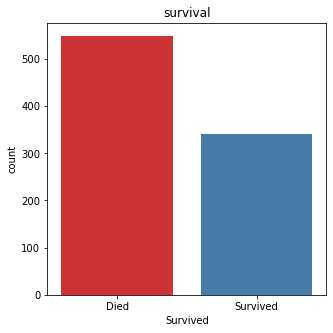

In [73]:
#Survive vs. Dead
fig, ax=plt.subplots(1,1, figsize=(5,5))
sns.countplot(data=df_train, x='Survived', ax=ax, palette="Set1")
ax.set_title('survival')
ax.set_xticklabels(['Died', 'Survived'])
plt.show()

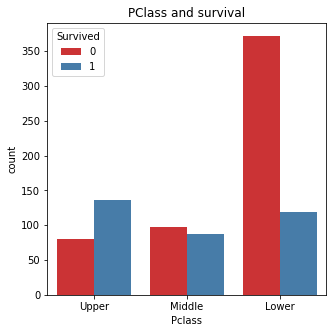

In [74]:
#Pclass and Survival

fig, ax=plt.subplots(1,1, figsize=(5,5))
sns.countplot(data=df_train, x='Pclass', ax=ax, hue='Survived',palette="Set1")
ax.set_title('PClass and survival')
ax.set_xticklabels(['Upper', 'Middle', 'Lower'])
plt.show()

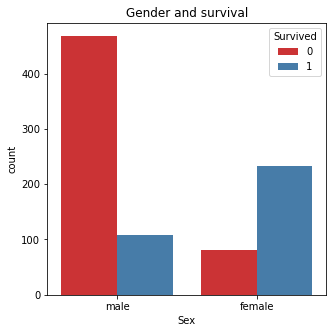

In [75]:
#Gender and Survival 

fig, ax=plt.subplots(1,1, figsize=(5,5))
sns.countplot(data=df_train, x='Sex', ax=ax, hue='Survived',palette="Set1")
ax.set_title('Gender and survival')
plt.show()

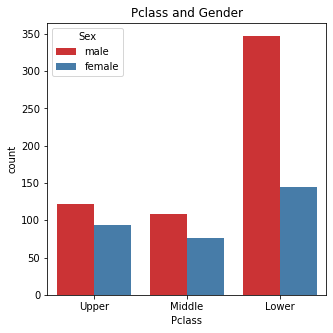

In [76]:
#Pclass and Gender 

fig, ax=plt.subplots(1,1, figsize=(5,5))
sns.countplot(data=df_train, x='Pclass', ax=ax, hue='Sex',palette="Set1")
ax.set_title('Pclass and Gender')
ax.set_xticklabels(['Upper', 'Middle', 'Lower'])
plt.show()

#survival : female > male. possibly because of lots of males in lower class
#maybe those in lower class = poor, labor class 

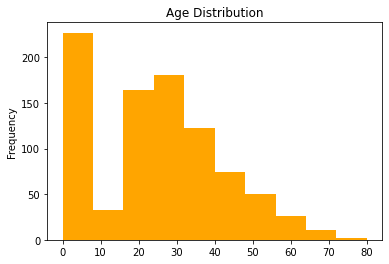

In [77]:
# Age
df_train.Age.plot(kind='hist', color='orange')
plt.title("Age Distribution")
plt.show()

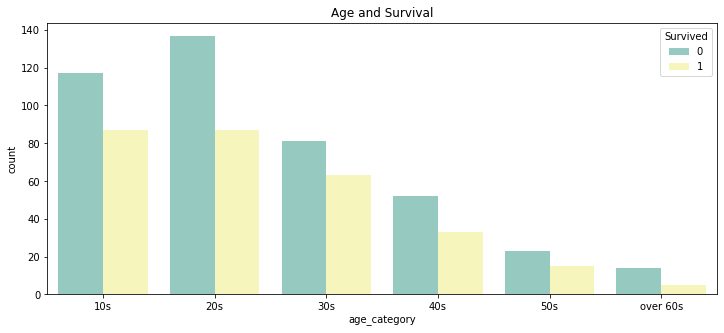

In [78]:
# categorizing
bins=[0,21,31,41,51,61,81]  
df_train['age_category']=pd.cut(df_train['Age'], bins, labels=['10s','20s','30s', '40s','50s','over 60s'])
df_train['age_category'].value_counts()

fig, ax=plt.subplots(1,1, figsize=(12,5))
sns.countplot(data=df_train, x='age_category', ax=ax, hue='Survived',palette="Set3" )
ax.set_title('Age and Survival')
plt.show()

# survival rate of infants(under 10s) = the highest among all age category
# the rest : survival  < mortality 

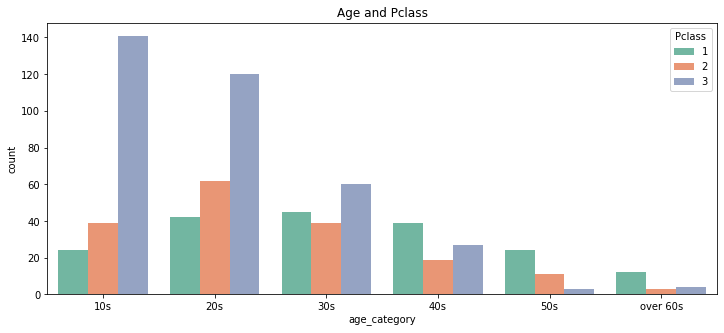

In [79]:
#see more details of age 

#Age and Pclass
fig, ax=plt.subplots(1,1, figsize=(12,5))
sns.countplot(data=df_train, x='age_category', ax=ax, hue='Pclass', palette='Set2')
ax.set_title("Age and Pclass")
plt.show()

# most youngs are in Pclass=3 
# So Pclass=1.. elder, rich 

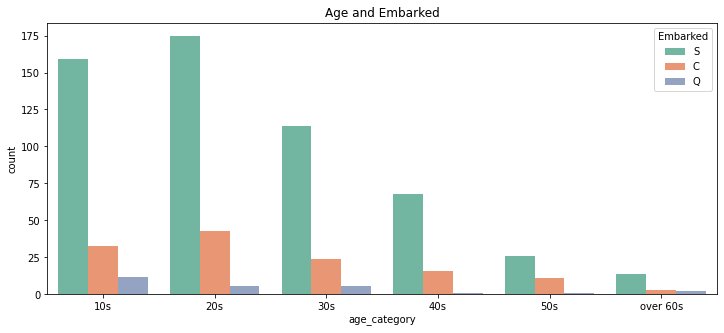

In [80]:
fig, ax=plt.subplots(1,1, figsize=(12,5))
sns.countplot(data=df_train, x='age_category', ax=ax, hue='Embarked', palette='Set2')
ax.set_title("Age and Embarked")
plt.show()

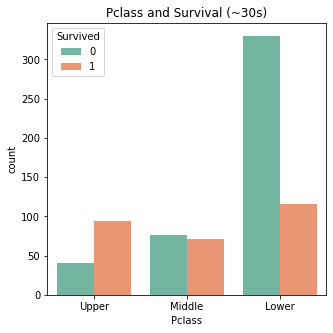

In [81]:
#how about the relation b/w Pclass and Survival? 
#first, let us look around among under 30s

temp= df_train.Age<40
df_temp=df_train[temp]
df_temp

fig, ax=plt.subplots(1,1, figsize=(5,5))
sns.countplot(data=df_temp, x='Pclass', ax=ax, hue='Survived', palette='Set2')
ax.set_title("Pclass and Survival (~30s)")
ax.set_xticklabels(['Upper','Middle','Lower'])
plt.show()

# Pclass (upper/middle vs. lower) is important to the survival of the young 

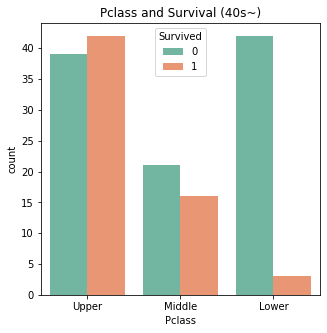

In [82]:
#second, let us look around among over 40s

temp= df_train.Age>=40
df_temp=df_train[temp]
df_temp

fig, ax=plt.subplots(1,1, figsize=(5,5))
sns.countplot(data=df_temp, x='Pclass', ax=ax, hue='Survived', palette='Set2')
ax.set_title("Pclass and Survival (40s~)")
ax.set_xticklabels(['Upper','Middle','Lower'])
plt.show()

# Pclass upper or middle seems not so significant to decide the survival rate, 
# but Pclass lower is obvious to lower the survival rate. 

# So, whether one was on Pclass 1,2 or 3 is important regardless of age 

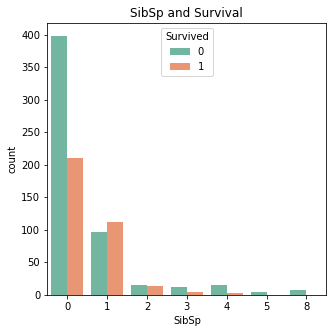

In [83]:
#SibSp and Survival rate 

fig, ax=plt.subplots(1,1, figsize=(5,5))
sns.countplot(data=df_train, x='SibSp', ax=ax, hue='Survived',palette="Set2")
ax.set_title('SibSp and Survival')
plt.show()


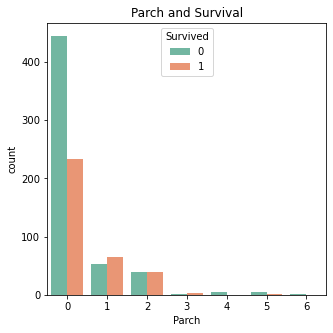

In [84]:
# Parch and Survival 
fig, ax=plt.subplots(1,1, figsize=(5,5))
sns.countplot(data=df_train, x='Parch', ax=ax, hue='Survived',palette="Set2")
ax.set_title('Parch and Survival')
plt.show()


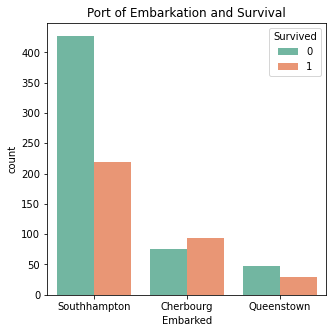

In [85]:
#Embarkation and Survival 

fig, ax=plt.subplots(1,1, figsize=(5,5))
sns.countplot(data=df_train, x='Embarked', ax=ax, hue='Survived',palette="Set2")
ax.set_title('Port of Embarkation and Survival')
ax.set_xticklabels(['Southhampton', 'Cherbourg', 'Queenstown'])
plt.show()

# Southhampton = the largest num boarded on. 
# Cherbourg : survival > moratality  

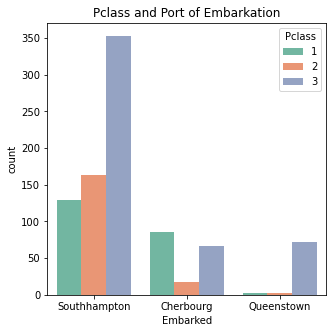

In [86]:
#Pclass and Embarkation port 

fig, ax=plt.subplots(1,1, figsize=(5,5))
sns.countplot(data=df_train, x='Embarked', ax=ax, hue='Pclass',palette="Set2")
ax.set_title('Pclass and Port of Embarkation')
ax.set_xticklabels(['Southhampton', 'Cherbourg', 'Queenstown'])
plt.show()


#Cherbourg = largest num in Upper class = most likely to survive .. may be those boarding on Cherbourg were mostly the rich? 
#Southhampton = largest num in lower class = least likely to survive. 

## 4. Modeling 
### 4.1 final datasets, one-hot encoding

In [89]:
#final datasets
# split X and y 
X=df_train.loc[:,['Pclass', 'Sex', 'SibSp', 'Parch','Embarked','Age','Ca']]
y=df_train.iloc[:,0]

In [90]:
X.info()  #no missing values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   SibSp     891 non-null    int64  
 3   Parch     891 non-null    int64  
 4   Embarked  891 non-null    object 
 5   Age       891 non-null    float64
 6   Ca        891 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 95.7+ KB


In [91]:
y.value_counts()/len(y)  #not balanced 

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [92]:
# categorical variables -> dummies by one hot encoding 

onehot_Pclass=pd.get_dummies(X['Pclass'], prefix='Pclass')
onehot_Sex=pd.get_dummies(X['Sex'], prefix='Sex')
onehot_em=pd.get_dummies(X['Embarked'], prefix='Em')
onehot_Ca=pd.get_dummies(X['Ca'], prefix='Ca')

X=pd.concat([X, onehot_Pclass], axis=1)
X=pd.concat([X, onehot_Sex], axis=1)
X=pd.concat([X, onehot_em], axis=1)
X=pd.concat([X, onehot_Ca], axis=1)

# and drop the variables. 
X.drop(['Pclass','Sex','Embarked','Ca'], axis=1, inplace=True)

### 4.2 Testing Models
XGBoost shows better performances according to cross validaiton.  
So choose XGBoost

In [94]:
#1st : RandomForest
from sklearn.ensemble import RandomForestClassifier 
model=RandomForestClassifier(
    n_estimators=1000,
    random_state=10,
    class_weight='balanced').fit(X,y)

# KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold 
cv = KFold(n_splits=5, shuffle=True, 
           random_state=11)

cv_scores=cross_val_score(
            model, X, y,
            cv=cv, scoring='accuracy', n_jobs=-1)

print(f'(CV) scores : \n{cv_scores}')
print(f'(CV) scores mean : \n{cv_scores.mean()}')

(CV) scores : 
[0.81005587 0.73033708 0.8258427  0.82022472 0.74719101]
(CV) scores mean : 
0.7867302743079531


In [95]:
# 2nd : DecisionTree 

from sklearn.tree import DecisionTreeClassifier 
dt_model=DecisionTreeClassifier(
    random_state=10,
    class_weight='balanced').fit(X,y)
dt_model.score(X,y)

# KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold 
cv = KFold(n_splits=5, shuffle=True, 
           random_state=11)

cv_scores=cross_val_score(
            dt_model, X, y,
            cv=cv, scoring='accuracy', n_jobs=-1)

print(f'(CV) scores : \n{cv_scores}')
print(f'(CV) scores mean : \n{cv_scores.mean()}')

(CV) scores : 
[0.74301676 0.74719101 0.82022472 0.81460674 0.76404494]
(CV) scores mean : 
0.7778168351013747


In [96]:
# 3rd : xgboost

import xgboost as xgb 
xgb_model=xgb.XGBClassifier(
        n_estimators=1000,
        subsample=0.5,
        reg_alpha=10,
        random_state=1).fit(X, y)

xgb_model.score(X,y)

# KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold 
cv = KFold(n_splits=5, shuffle=True, 
           random_state=11)

cv_scores=cross_val_score(
            xgb_model, X, y,
            cv=cv, scoring='accuracy', n_jobs=-1)

print(f'(CV) scores : \n{cv_scores}')
print(f'(CV) scores mean : \n{cv_scores.mean()}')

(CV) scores : 
[0.87709497 0.76966292 0.85393258 0.80898876 0.78651685]
(CV) scores mean : 
0.8192392191325089


In [97]:
# 4th : KNN 

from sklearn.neighbors import KNeighborsClassifier 

knn_model=KNeighborsClassifier(n_neighbors=5).fit(X,y)
knn_model.score(X,y)

# KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold 
cv = KFold(n_splits=5, shuffle=True, 
           random_state=11)

cv_scores=cross_val_score(
            knn_model, X, y,
            cv=cv, scoring='accuracy', n_jobs=-1)

print(f'(CV) scores : \n{cv_scores}')
print(f'(CV) scores mean : \n{cv_scores.mean()}')

(CV) scores : 
[0.83240223 0.71910112 0.7752809  0.80337079 0.76404494]
(CV) scores mean : 
0.778839997489172


In [98]:
#Logistic Regression 

from sklearn.linear_model import LogisticRegression
lr_model=LogisticRegression(
    C=0.01, max_iter=1000).fit(X,y)

lr_model.score(X,y)

# KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold 
cv = KFold(n_splits=5, shuffle=True, 
           random_state=11)

cv_scores=cross_val_score(
            lr_model, X, y,
            cv=cv, scoring='accuracy', n_jobs=-1)

print(f'(CV) scores : \n{cv_scores}')
print(f'(CV) scores mean : \n{cv_scores.mean()}')

(CV) scores : 
[0.84916201 0.73595506 0.83707865 0.80898876 0.79213483]
(CV) scores mean : 
0.8046638629087942


4.3 Find Best Parameters / XGBoost

In [99]:
# Find Best Parameters

# KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV

param_grid = { 
    'n_estimators': [300, 500, 1000],
    'subsample': [0.3, 0.5, 0.7],
    'reg_alpha' : [1, 10, 20]
}

cv = KFold(n_splits=5, shuffle=True, 
           random_state=11)

base_model = xgb.XGBClassifier(
        random_state=1).fit(X, y)


grid_model = GridSearchCV(
                base_model,
                param_grid=param_grid)

grid_model.fit(X, y)

print(f'best_score : {grid_model.best_score_}')
print(f'best_params : \n{grid_model.best_params_}')


best_score : 0.8271483271608814
best_params : 
{'n_estimators': 500, 'reg_alpha': 1, 'subsample': 0.3}


In [100]:
# fitting model
xgb_model.fit(X, y)
score = xgb_model.score(X, y)
print(f'(MODEL) TRAIN SCORE : {score}')

(MODEL) TRAIN SCORE : 0.8529741863075196


## [4] test data import, preprocessing

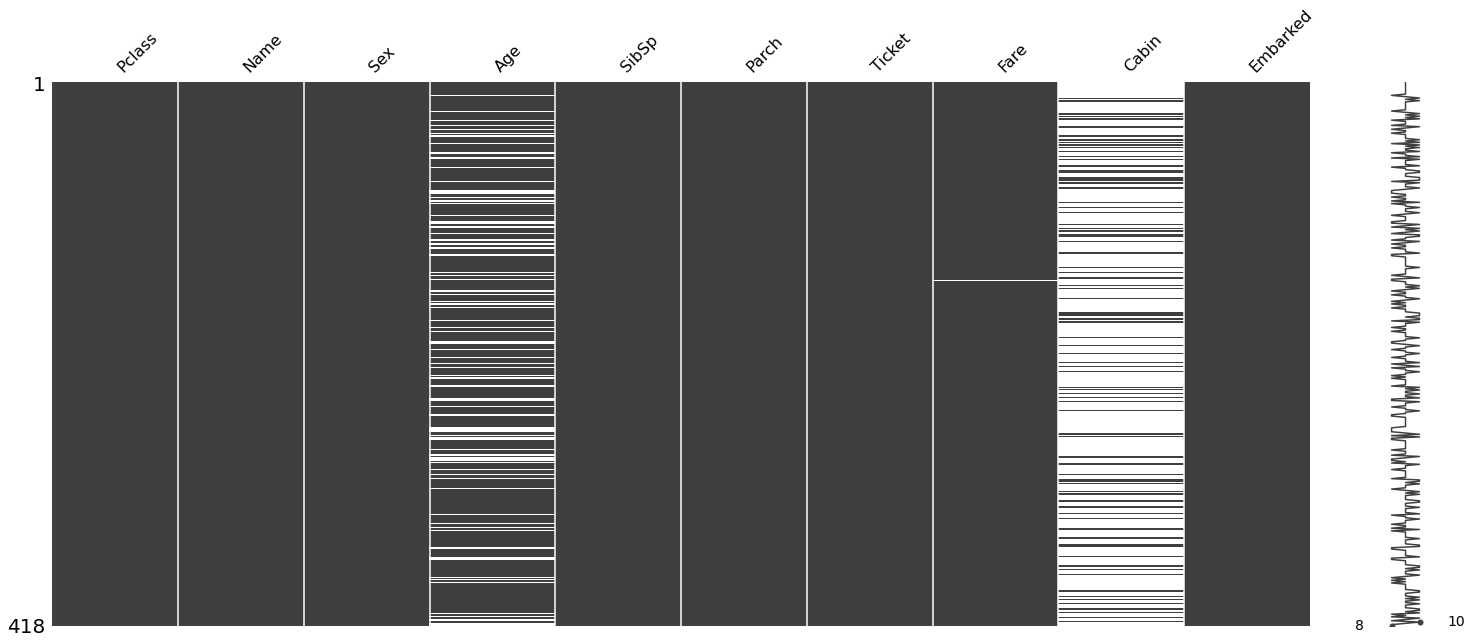

In [101]:
df_test = pd.read_csv("../input/titanic/test.csv")
df_test.set_index('PassengerId', inplace=True)
msno.matrix(df_test)

In [102]:
# filling missing values - Age 
#replace Age of [Pclass=1] with 30s.. just pick 35.
age_Pc_sex = df_test.groupby(['Sex', 'Pclass']).median()['Age']
df_test['Age']=df_test.groupby(['Sex','Pclass'])['Age'].apply(lambda x : x.fillna(x.median()))



# filling missing values - Cabin 
df_test['Ca']='NaN'

df_A = df_test.Cabin.str.contains('A') 
temp_index=df_test[df_A==True].index
df_test.loc[temp_index, 'Ca']='A'

df_B = df_test.Cabin.str.contains('B') 
temp_index=df_test[df_B==True].index
df_test.loc[temp_index, 'Ca']='B'

df_C = df_test.Cabin.str.contains('C') 
temp_index=df_test[df_C==True].index
df_test.loc[temp_index, 'Ca']='C'

df_D = df_test.Cabin.str.contains('D') 
temp_index=df_test[df_D==True].index
df_test.loc[temp_index, 'Ca']='D'

df_E = df_test.Cabin.str.contains('E') 
temp_index=df_test[df_E==True].index
df_test.loc[temp_index, 'Ca']='E'

df_F = df_test.Cabin.str.contains('F') 
temp_index=df_test[df_F==True].index
df_test.loc[temp_index, 'Ca']='F'

df_G = df_test.Cabin.str.contains('G') 
temp_index=df_test[df_G==True].index
df_test.loc[temp_index, 'Ca']='G'

df_test.Ca.replace('NaN', 'X', inplace=True)  #Pclass=2,3


In [103]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       418 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
 10  Ca        418 non-null    object 
dtypes: float64(2), int64(3), object(6)
memory usage: 59.2+ KB


In [113]:
X_test=df_test.loc[:,['Pclass', 'Sex', 'SibSp', 'Parch','Embarked','Ca', 'Age']]
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   SibSp     418 non-null    int64  
 3   Parch     418 non-null    int64  
 4   Embarked  418 non-null    object 
 5   Ca        418 non-null    object 
 6   Age       418 non-null    float64
dtypes: float64(1), int64(3), object(3)
memory usage: 46.1+ KB


In [114]:
onehot_Pclass=pd.get_dummies(X_test['Pclass'], prefix='Pclass')
onehot_Sex=pd.get_dummies(X_test['Sex'], prefix='Sex')
onehot_em=pd.get_dummies(X_test['Embarked'], prefix='Em')
onehot_Ca=pd.get_dummies(X_test['Ca'], prefix='Ca')

X_test=pd.concat([X_test, onehot_Pclass], axis=1)
X_test=pd.concat([X_test, onehot_Sex], axis=1)
X_test=pd.concat([X_test, onehot_em], axis=1)
X_test=pd.concat([X_test, onehot_Ca], axis=1)

# and drop the varialbes. 
X_test.drop(['Pclass','Sex','Embarked','Ca'], axis=1, inplace=True)

In [115]:
y_preds = model.predict(X_test)

In [116]:
submission = pd.DataFrame({'PassengerId':df_test.index, 
              'Survived':y_preds})
submission.to_csv('submission2.csv', index=False)
pd.read_csv('submission2.csv')

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
